In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# this function classifies asteroids based on their orbits
def compute_orbit_type(df):
    q = df["q"].values
    e = df["e"].values
    i = df["inc"].values

    # Derived quantities
    a = q / (1 - e)
    Q = a * (1 + e)
    T = (5.2 / a) + 2 * np.cos(np.radians(i)) * np.sqrt((a / 5.2) * (1 - e**2))

    # Constants
    a_jup = 5.2
    a_nep = 30.1
    q_mars = 1.666

    # Default to "Unusual Other"
    result = np.full(len(df), "bokiccc") # "bokiccc" can be replaced by any other string longer than any string assigned using the assign function 
    unclassified = np.full(len(df), True)

    def assign(mask, code):
        nonlocal result, unclassified
        update = mask & unclassified
        result[update] = code
        unclassified[update] = False
    # here, all classifications are divided into 4 groups
    # you can rename them by just changing the string, but then all following code needs to be modified
    assign(e > 1, 'TNO')                                  # Hyperbolic
    assign(e == 1, 'TNO')                                 # Parabolic
    assign((a < 1) & (Q < 0.983), 'NEO')                   # Atira
    assign((a < 1) & (Q >= 0.983), 'NEO')                  # Aten
    assign((a >= 1) & (q < 1.017), 'NEO')                  # Apollo
    assign((a >= 1) & (q >= 1.017) & (q < 1.3), 'NEO')     # Amor
    assign((a >= 1) & (Q < q_mars), 'MBA')                 # Inner Other
    assign((1 <= a) & (a < 3.2) & (q >= 1.3) & (q < q_mars), 'MBA')  # Mars Crosser
    assign((1 <= a) & (a < 3.27831) & (i < 75), 'MBA')    # Main Belt
    assign((4.8 < a) & (a < 5.4) & (e < 0.3), 'trojan')      # Jupiter Trojan
    assign((a < a_jup), 'MBA')                            # Middle Other
    assign((a >= 1) & (T > 2) & (T < 3), 'TNO')           # Jupiter Coupled
    assign((29.8 < a) & (a < 30.4), 'TNO')                # Neptune Trojan
    assign((a_jup <= a) & (a < a_nep), 'TNO')             # Centaur
    assign((a >= a_nep), 'TNO')                           # TNO

    return result


In [97]:
# orbits_real.csv has data about asteroid orbits 
# replace the string with the file path
df_orbits = pd.read_csv('../results/real_data/orbits.csv')
# here, a column 'type' is added to the orbits file
df_orbits['type']=compute_orbit_type(df_orbits)

In [98]:
# e2e_real.csv contains results of the sorcha simulation using known asteroids
# instructions for getting these results should be found in a folder 'simulations'
# replace the string with the file path
df_real = pd.read_csv('../results/real_data/e2e.csv')
# here, a column 'type' is added to simulation results by matching object IDs with the orbits file
df_real_types=df_real.merge(df_orbits[["type","ObjID"]],on="ObjID")

In [13]:
# these files contain results of 4 sorcha simulations using simulated asteroids, divided by type
# instructions for getting these results should be found in a folder 'simulations'
# NOTE - simulations for NEOs were downsampled by a factor of 10 so their results will be multiplied by 10
df_mba = pd.read_csv('../results/sim-outputs/mba/e2e_mba.csv')
df_neo = pd.read_csv('../results/sim-outputs/neo/e2e_neo.csv')
df_tno = pd.read_csv('../results/sim-outputs/tno/e2e_tno.csv')
df_trojans = pd.read_csv('../results/sim-outputs/trojans/e2e_trojans.csv')

In [99]:
# those 4 files are combined into one and types are specified
df1 = df_mba.copy()
df1['type'] = 'MBA'
df2 = df_neo.copy()
df2['type'] = 'NEO'
df3 = df_tno.copy()
df3['type'] = 'TNO'
df4 = df_trojans.copy()
df4['type'] = 'trojan'

df_concat = pd.concat([df1, df2, df3, df4], axis=0)

df_sim_types = df_concat.sort_values(by='fieldMJD_TAI').reset_index(drop=True)

In [16]:
# this prints the number of unique IDs observed of known asteroids
print('MBA: '+str(df_real_types.query("type=='MBA'")['ObjID'].nunique()))
print('NEO: '+str(df_real_types.query("type=='NEO'")['ObjID'].nunique()))
print('TNO: '+str(df_real_types.query("type=='TNO'")['ObjID'].nunique()))
print('trojans: '+str(df_real_types.query("type=='trojan'")['ObjID'].nunique()))

MBA: 203144
NEO: 426
TNO: 335
trojans: 43


In [18]:
# this prints the number of unique IDs observed of simulated asteroids
print('MBA: '+str(df_sim_types.query("type=='MBA'")['ObjID'].nunique()))
print('NEO: '+str(df_sim_types.query("type=='NEO'")['ObjID'].nunique()*10))
print('TNO: '+str(df_sim_types.query("type=='TNO'")['ObjID'].nunique()))
print('trojans: '+str(df_sim_types.query("type=='trojan'")['ObjID'].nunique()))

MBA: 393122
NEO: 14260
TNO: 1959
trojans: 50


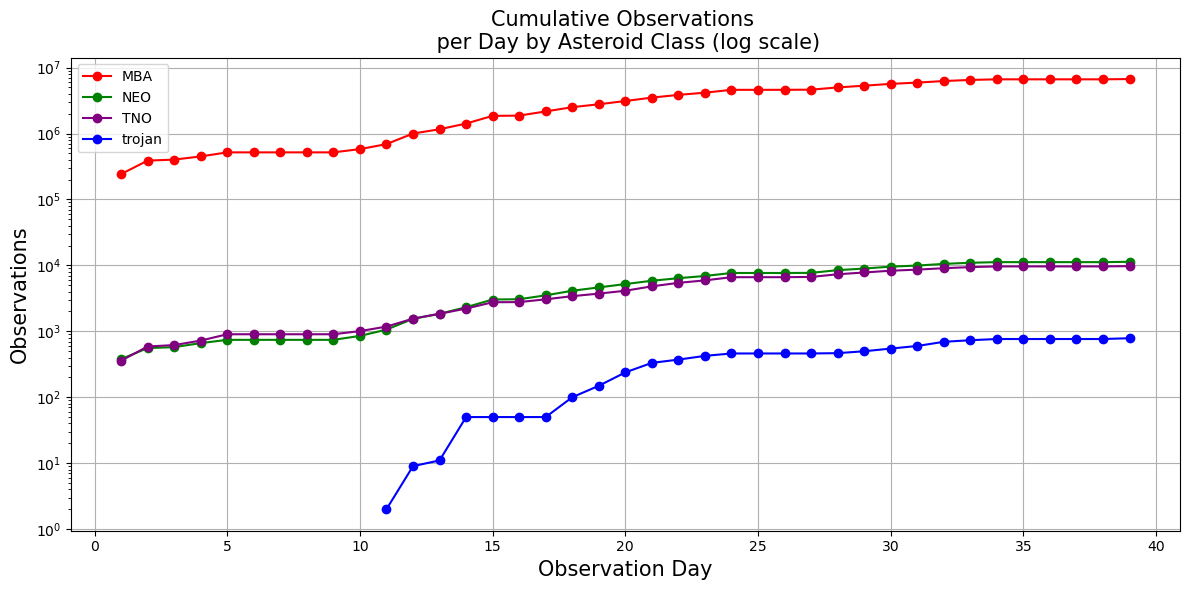

In [100]:
dfcopyRealTypes=df_real_types.copy()

#this makes line graphs from known asteroid observations

#change settings
CUMULATIVE=True 
FIRSTID=False
LOG_SCALE=True
files = {# put a line in a comment to ignore that group
    'MBA': {'label': 'MBA', 'color': 'red'},
    'NEO': {'label': 'NEO', 'color': 'green'},
    'TNO': {'label': 'TNO', 'color': 'purple'},
    'trojan': {'label': 'trojan', 'color': 'blue'}
}
class_data = {}

for file, info in files.items():
    df = dfcopyRealTypes.query(f"type == '{file}'").copy()
    if FIRSTID:
        df = df.drop_duplicates(subset='ObjID', keep='first')

    df['day'] = (df['fieldMJD_TAI']-60846).astype(int)
    
    daily_counts = df.groupby('day').size().reset_index(name='count')
    all_days = np.arange(1, 40)
    daily_counts = daily_counts.set_index('day').reindex(all_days, fill_value=np.nan).reset_index()
    daily_counts.rename(columns={'index': 'day'}, inplace=True)
    
    if CUMULATIVE:
        daily_counts['plot'] = daily_counts['count'].cumsum()
        daily_counts['plot'] = daily_counts['plot'].ffill()
    else:
        daily_counts['plot'] = daily_counts['count']
    
    class_data[info['label']] = {
        'day': daily_counts['day'],
        'plot': daily_counts['plot'],
        'color': info['color']
    }


plt.figure(figsize=(12, 6))

for label, data in class_data.items():
    plt.plot(data['day'], data['plot'], label=label, color=data['color'],marker='o', linestyle='-')

plt.xlabel('Observation Day',size=15)
plt.ylabel('Observations',size=15)
title='Observations \n per Day by Asteroid Class'
if FIRSTID:
    title='First-time ID '+title
if CUMULATIVE:
    title='Cumulative '+title
if LOG_SCALE:
    plt.yscale('log')
    title=title+' (log scale)'
plt.title(title,size=15)
plt.legend()
plt.grid(True)
plt.tight_layout()


<Figure size 1400x600 with 0 Axes>

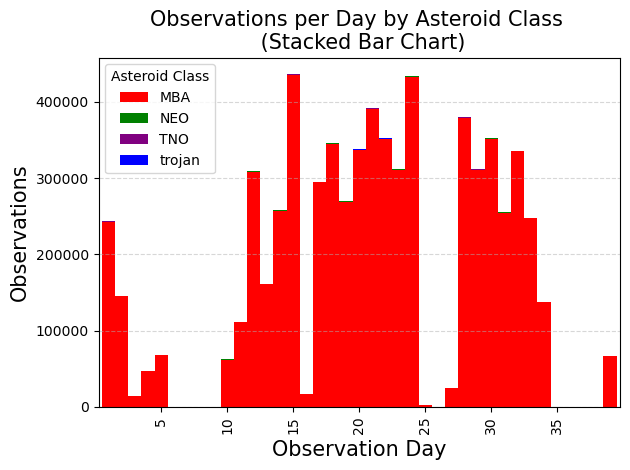

In [101]:
from functools import reduce

dfcopyRealTypes=df_real_types.copy()

#this makes stacked bar graphs from known asteroid observations

#change settings
CUMULATIVE=False 
FIRSTID=False

files = { # put a line in a comment to ignore that group
    'MBA': 'MBA',
    'NEO': 'NEO',
    'TNO': 'TNO',
    'trojan': 'trojan' 
}
colors = {
    'MBA': 'red',
    'trojan': 'blue',
    'NEO': 'green',
    'TNO': 'purple'
}
all_counts = []

for file, class_name in files.items():
    df = dfcopyRealTypes.query(f"type == '{file}'").copy()
    df['mjd_day'] = (df['fieldMJD_TAI'] - 60846).astype(int)
    if FIRSTID:
        first_seen = df.drop_duplicates(subset='ObjID', keep='first')
        daily = first_seen.groupby('mjd_day').size().reset_index(name=class_name)
    else:
        daily = df.groupby('mjd_day').size().reset_index(name=class_name)
    all_counts.append(daily)

df_merged = reduce(lambda left, right: pd.merge(left, right, on='mjd_day', how='outer'), all_counts)
df_merged = df_merged.fillna(0)

full_range = pd.RangeIndex(1, 40)
df_merged = df_merged.set_index('mjd_day').reindex(full_range, fill_value=0)

if CUMULATIVE:
    for class_name in files.values():
        df_merged[class_name] = df_merged[class_name].cumsum()

plt.figure(figsize=(14, 6))
if CUMULATIVE:
    df_merged.plot.area(color=[colors[c] for c in files.values()])
else:
    df_merged.plot(kind='bar', stacked=True, color=[colors[c] for c in files.values()], width=1.0)
plt.xlabel('Observation Day',size=15)
plt.ylabel('Observations',size=15)
plt.title('Observations per Day by Asteroid Class \n (Stacked Bar Chart)',size=15)
if FIRSTID:
    plt.title('First-time ID Observations per Day \n by Asteroid Class (Stacked Bar Chart)',size=15)
if CUMULATIVE:
    plt.title('Cumulative Observations per Day by \n Asteroid Class (Stacked Bar Chart)',size=15)
    if FIRSTID:
        plt.title('Cumulative First-time ID Observations per Day \n by Asteroid Class (Stacked Bar Chart)',size=15)
plt.legend(title='Asteroid Class')
plt.grid(axis='y', linestyle='--', alpha=0.5)

if CUMULATIVE==False:
    xticks_interval = 5
    xticks = np.arange(4, 39, xticks_interval)
    plt.xticks(xticks)
plt.tight_layout()

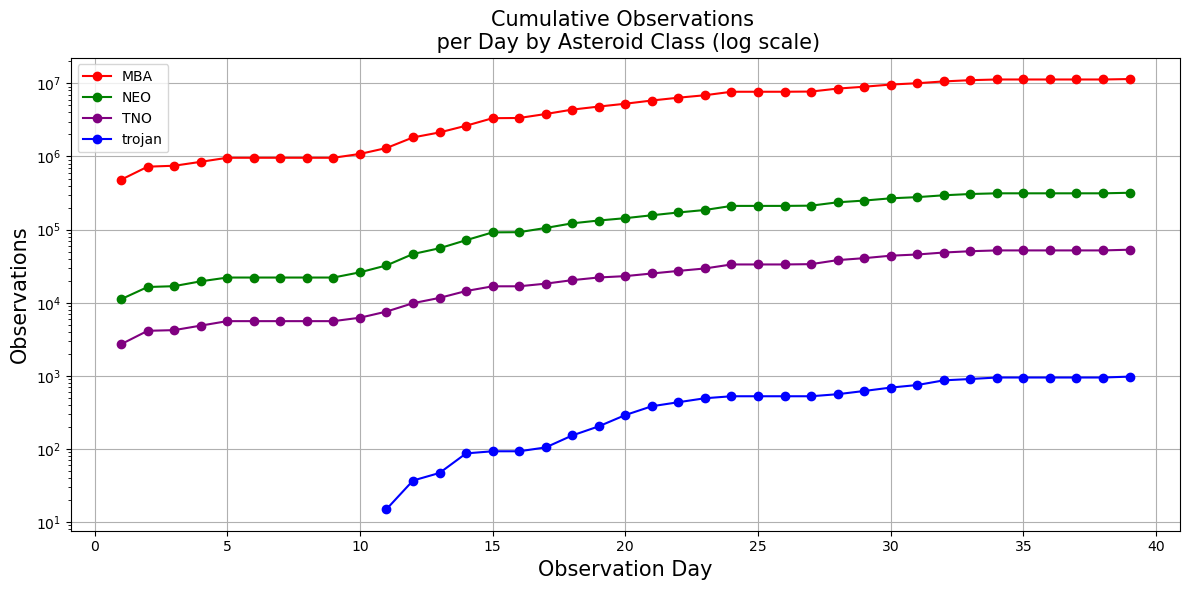

In [102]:
dfcopySimTypes=df_sim_types.copy()

#this makes line graphs from simulated asteroid observations

#change settings
CUMULATIVE=True 
FIRSTID=False
LOG_SCALE=True

files = {# put a line in a comment to ignore that group
    'MBA': {'label': 'MBA', 'color': 'red'},
    'NEO': {'label': 'NEO', 'color': 'green'},
    'TNO': {'label': 'TNO', 'color': 'purple'},
    'trojan': {'label': 'trojan', 'color': 'blue'}
}
class_data = {}

for file, info in files.items():
    df = dfcopySimTypes.query(f"type == '{file}'").copy()
    if FIRSTID:
        df = df.drop_duplicates(subset='ObjID', keep='first')
    df['day'] = (df['fieldMJD_TAI']-60846).astype(int)
    
    daily_counts = df.groupby('day').size().reset_index(name='count')
    if info['label'] == 'NEO':
        daily_counts['count'] = daily_counts['count'] * 10
    
    all_days = np.arange(1, 40)
    daily_counts = daily_counts.set_index('day').reindex(all_days, fill_value=np.nan).reset_index()
    daily_counts.rename(columns={'index': 'day'}, inplace=True)
    
    if CUMULATIVE:
        daily_counts['plot'] = daily_counts['count'].cumsum()
        daily_counts['plot'] = daily_counts['plot'].ffill()
    else:
        daily_counts['plot'] = daily_counts['count']
    
    class_data[info['label']] = {
        'day': daily_counts['day'],
        'plot': daily_counts['plot'],
        'color': info['color']
    }


plt.figure(figsize=(12, 6))

for label, data in class_data.items():
    plt.plot(data['day'], data['plot'], label=label, color=data['color'],marker='o', linestyle='-')

plt.xlabel('Observation Day',size=15)
plt.ylabel('Observations',size=15)
title='Observations \n per Day by Asteroid Class'
if FIRSTID:
    title='First-time ID '+title
if CUMULATIVE:
    title='Cumulative '+title
if LOG_SCALE:
    plt.yscale('log')
    title=title+' (log scale)'
plt.title(title,size=15)
plt.legend()
plt.grid(True)
plt.tight_layout()


<Figure size 1400x600 with 0 Axes>

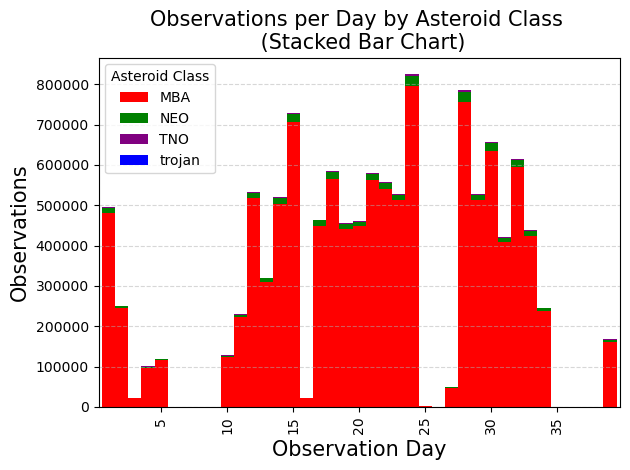

In [103]:
from functools import reduce

dfcopySimTypes=df_sim_types.copy()

#this makes stacked bar graphs from known asteroid observations

#change settings
CUMULATIVE=False 
FIRSTID=False

files = { # put a line in a comment to ignore that group
    'MBA': 'MBA',
    'NEO': 'NEO',
    'TNO': 'TNO',
    'trojan': 'trojan' 
}
colors = {
    'MBA': 'red',
    'trojan': 'blue',
    'NEO': 'green',
    'TNO': 'purple'
}
all_counts = []

for file, class_name in files.items():
    df = dfcopySimTypes.query(f"type == '{file}'").copy()
    df['mjd_day'] = (df['fieldMJD_TAI'] - 60846).astype(int)
    if FIRSTID:
        first_seen = df.drop_duplicates(subset='ObjID', keep='first')
        daily = first_seen.groupby('mjd_day').size().reset_index(name=class_name)
        if class_name == 'NEO':
            daily[class_name] = daily[class_name] * 10
    else:
        daily = df.groupby('mjd_day').size().reset_index(name=class_name)
        if class_name == 'NEO':
            daily[class_name] = daily[class_name] * 10
    all_counts.append(daily)

df_merged = reduce(lambda left, right: pd.merge(left, right, on='mjd_day', how='outer'), all_counts)
df_merged = df_merged.fillna(0)

full_range = pd.RangeIndex(1, 40)
df_merged = df_merged.set_index('mjd_day').reindex(full_range, fill_value=0)

if CUMULATIVE:
    for class_name in files.values():
        df_merged[class_name] = df_merged[class_name].cumsum()

plt.figure(figsize=(14, 6))
if CUMULATIVE:
    df_merged.plot.area(color=[colors[c] for c in files.values()])
else:
    df_merged.plot(kind='bar', stacked=True, color=[colors[c] for c in files.values()], width=1.0)
plt.xlabel('Observation Day',size=15)
plt.ylabel('Observations',size=15)
plt.title('Observations per Day by Asteroid Class \n (Stacked Bar Chart)',size=15)
if FIRSTID:
    plt.title('First-time ID Observations per Day \n by Asteroid Class (Stacked Bar Chart)',size=15)
if CUMULATIVE:
    plt.title('Cumulative Observations per Day by \n Asteroid Class (Stacked Bar Chart)',size=15)
    if FIRSTID:
        plt.title('Cumulative First-time ID Observations per Day \n by Asteroid Class (Stacked Bar Chart)',size=15)
plt.legend(title='Asteroid Class')
plt.grid(axis='y', linestyle='--', alpha=0.5)

if CUMULATIVE==False:
    xticks_interval = 5
    xticks = np.arange(4, 39, xticks_interval)
    plt.xticks(xticks)
plt.tight_layout()

ObjID
K07C17B    134
K15RP6U    133
K04N31J    132
K10W45V    131
K21M11Z    130
Name: count, dtype: int64


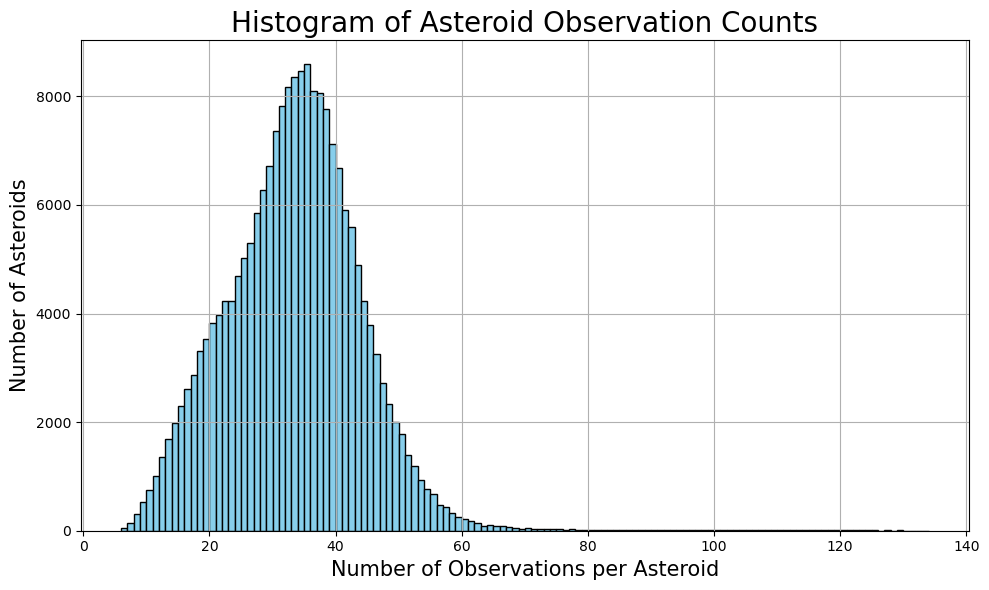

In [104]:
#makes a histogram of asteroid observations

#change datafile, keep one of these as a comment

#df_selected=df_sim_types.copy()
df_selected=df_real_types.copy()

obs_counts = df_selected['ObjID'].value_counts()
unique_values = np.unique(obs_counts)

plt.figure(figsize=(10, 6))
plt.hist(obs_counts, bins=np.arange(min(unique_values), max(unique_values) + 1), color='skyblue', edgecolor='black')
plt.xlabel('Number of Observations per Asteroid',size=15)
plt.ylabel('Number of Asteroids',size=15)
plt.title('Histogram of Asteroid Observation Counts',size=20)
plt.grid(True)
plt.tight_layout()

#prints the 5 most observed asteroids and number of observations
#use the ID to show them on a map in the following code
print(obs_counts.head())

In [105]:
# choose asteroid to show on maps by selecting ID
TARGET_ID = 'K07C17B'

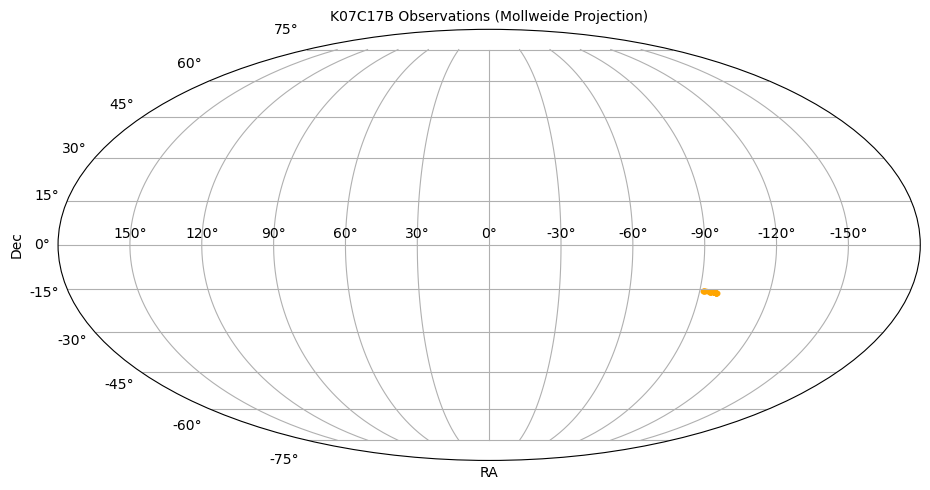

In [109]:
# makes a mollweide projection map of the sky where an asteroid was observed

#change datafile, keep one of these as a comment
#df_selected=df_sim_types.copy()
df=df_real_types.copy()

obj_df = df[df['ObjID'] == TARGET_ID]
ra_shifted = obj_df['RA_deg'].apply(lambda x: 360 - x if x > 180 else -x)
ra_rad = np.deg2rad(ra_shifted)
dec_rad = np.deg2rad(obj_df['Dec_deg'])

plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='mollweide')
ax.set_xticks(np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]))
ax.set_xticklabels(['150°', '120°', '90°', '60°', '30°', '0°', '-30°', '-60°', '-90°', '-120°', '-150°'])    
ax.set_xlabel('RA',size=10)
ax.set_ylabel('Dec',size=10)
ax.set_title(f'{TARGET_ID} Observations (Mollweide Projection)', size=10)
ax.grid(True)
ax.scatter(ra_rad, dec_rad, s=10, color='orange', alpha=0.7)
plt.tight_layout()

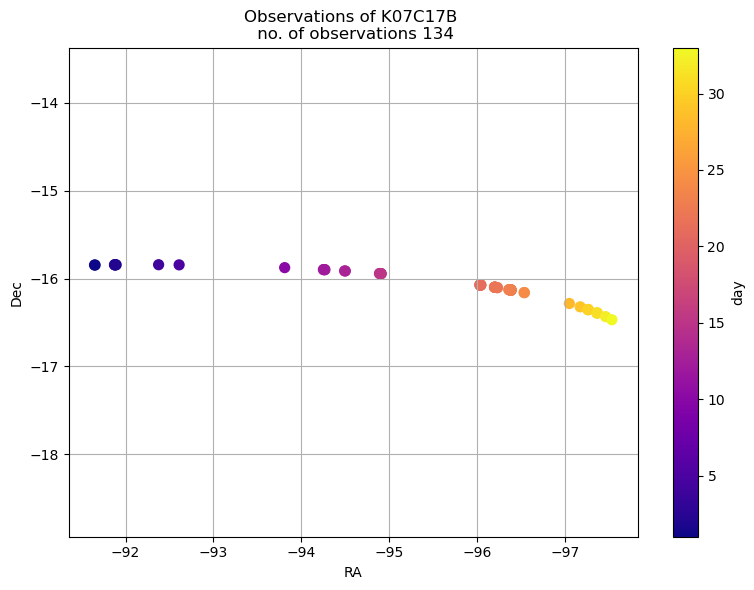

In [107]:
# makes a zoomed in map of the sky where an asteroid was observed

#change datafile, keep one of these as a comment
#df_selected=df_sim_types.copy()
df=df_real_types.copy()

df['mjd_day'] = (df['fieldMJD_TAI']-60846).astype(int)
obj_df = df[df['ObjID'] == TARGET_ID]
ra_shifted = obj_df['RA_deg'].apply(lambda x: x-360 if x > 180 else x)
plt.figure(figsize=(8, 6))
plt.scatter(ra_shifted, obj_df['Dec_deg'], c=obj_df['mjd_day'], cmap='plasma', s=50)
plt.gca().invert_xaxis()
plt.colorbar(label='day')
plt.xlabel('RA',size=10)
plt.ylabel('Dec',size=10)
plt.title(f'Observations of {TARGET_ID} \n no. of observations {len(ra_shifted)}')
plt.axis('equal')
plt.grid(True)
plt.tight_layout()

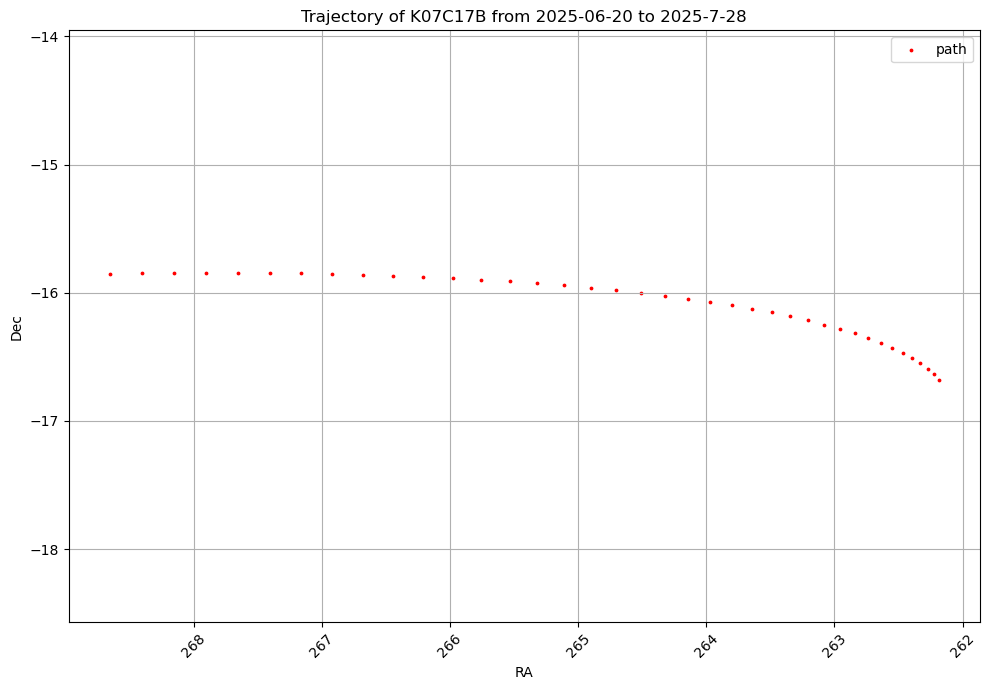

In [108]:
from astroquery.jplhorizons import Horizons

from datetime import datetime, timedelta

# makes a map of an asteroid's location on the night sky over a time range

# choose asteroid to show by selecting ID, other objects in space have names in Horizons
TARGET_ID = 'K07C17B'

#select start and end dates and time between points
#dates in format YYYY-MM-DD
#observations were made from 2025-07-20 to 2025-7-28
start_date='2025-06-20'
stop_date='2025-7-28'
#steps in format (number of days)+d ex. 1d or 5d or 10d
step='1d'

asteroid = Horizons(id=TARGET_ID, location='500', epochs={'start':start_date, 'stop':stop_date, 'step':step})



# Get the ephemerides (RA, Dec) for the asteroid over the specified period
ephemerides = asteroid.ephemerides()

# Extract the RA and Dec from the ephemerides data
ra = ephemerides['RA']
ra_shifted = obj_df['RA_deg'].apply(lambda x: x-360 if x > 180 else x)
dec = ephemerides['DEC']
times = ephemerides['datetime_jd']

# Plotting RA vs Dec
plt.figure(figsize=(10, 7))
#plt.plot(times, ra, label='Right Ascension (RA)', color='b')
plt.scatter(ra, dec, label='path', color='r', s=3)
plt.gca().invert_xaxis()
plt.axis('equal')

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title(f'Trajectory of {TARGET_ID} from {start_date} to {stop_date}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

In [94]:
##########
#########
########
#######
######
#####
####
###
##
# code after this shows data related to observation magnitude

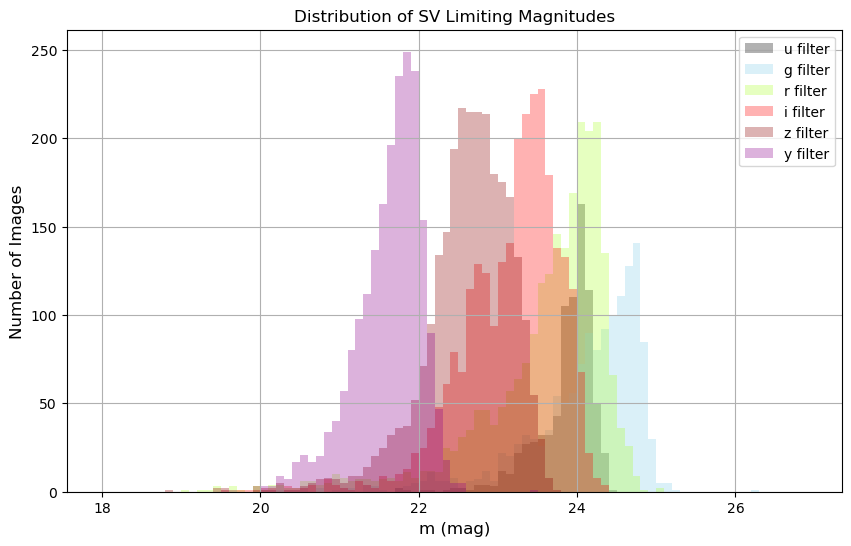

In [92]:
import sqlite3
# this makes a histogram of limiting magnitudes for observations split by filters

# sv_20250729.db has lots of data about observations the Rubin observatory made (and some data about future observations, but we aren't using that)

conn=sqlite3.connect("../data/sv_20250729.db")
dfobs=pd.read_sql_query("SELECT * FROM observations", conn)
conn.close()

dfr2_neo = dfrealtypescolors.query("type == 'NEO'")['H_r']
df3_data = df_neocolor['H_r']

filters=['u','g','r','i','z','y']
colors=['black','skyblue','greenyellow','red','darkred','darkmagenta']

plt.figure(figsize=(10, 6))
bins=np.arange(18, 27, 0.1)
for i in range(6):
    a=i
    df_filtered=dfobs.query(f"observationStartMJD < 60886 and band == '{filters[i]}'")['fiveSigmaDepth']
    plt.hist(df_filtered, bins=bins, alpha=0.3, label=filters[i]+' filter', color=colors[i])

plt.xlabel('m (mag)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of SV Limiting Magnitudes', fontsize=12)
plt.legend()
plt.grid(True)


In [95]:
# colors.csv has data about asteroid absolute magnitudes and colors
# replace the string with the file path
df_colors=pd.read_csv('../results/real_data/colors.csv')
df_temp=df_real_types.copy()
# here, a column 'H_r' is added to simulation results by matching object IDs with the colors file
dfrealtypescolors=df_temp.merge(df_colors[["H_r","ObjID"]],on="ObjID")

array([[<Axes: title={'center': 'H_r'}>]], dtype=object)

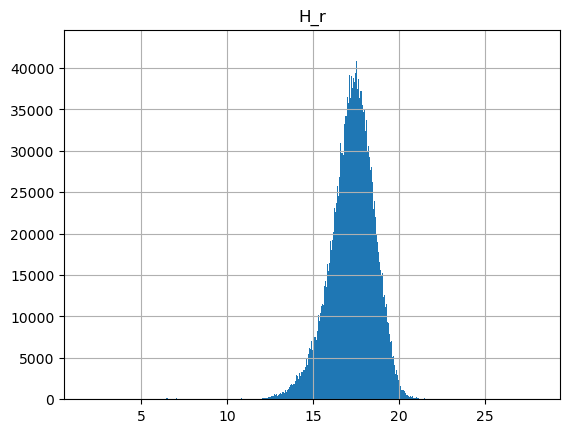

In [96]:
# makes a histogram of absolute magnitudes of observed known asteroids
dfrealtypescolors.hist('H_r', bins='fd')

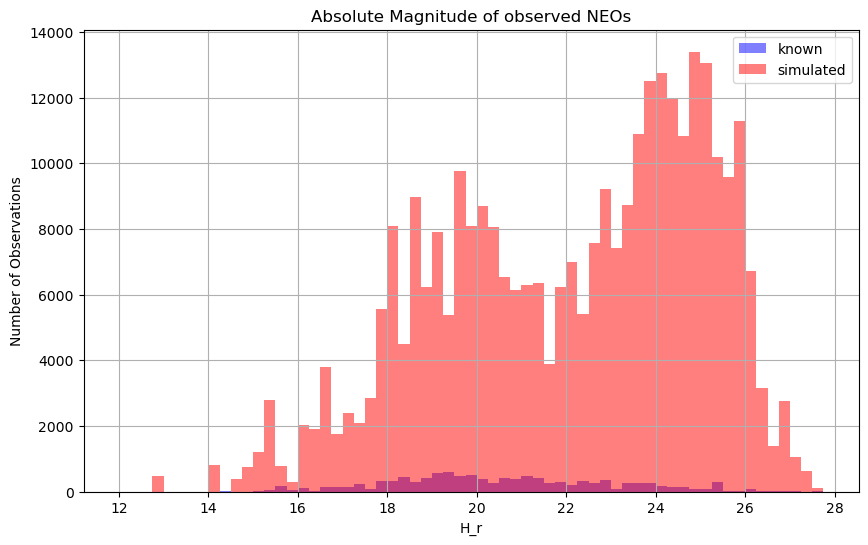

In [120]:
# makes histograms of absolute magnitudes of observed NEOs
# this is because TNOs don't have a file with all colors data 

df_colors_neo=pd.read_csv('../results/sim-outputs/neo/colors_neo.csv')
df_neotemp=df_neo.copy()
df_neocolor=df_neotemp.merge(df_colors_neo[["H_r","ObjID"]],on="ObjID")

dfr2_neo = dfrealtypescolors.query("type == 'NEO'")['H_r']
df3_data = df_neocolor['H_r']

df3_data10 = np.tile(df3_data, 10)
plt.figure(figsize=(10, 6))
bins=np.arange(12, 28, 0.25)
plt.hist(dfr2_neo, bins=bins, alpha=0.5, label='known', color='blue')

plt.hist(df3_data10, bins=bins, alpha=0.5, label='simulated', color='red')

plt.title('Absolute Magnitude of observed NEOs')
plt.xlabel('H_r')
plt.ylabel('Number of Observations')
plt.legend()
plt.grid(True)

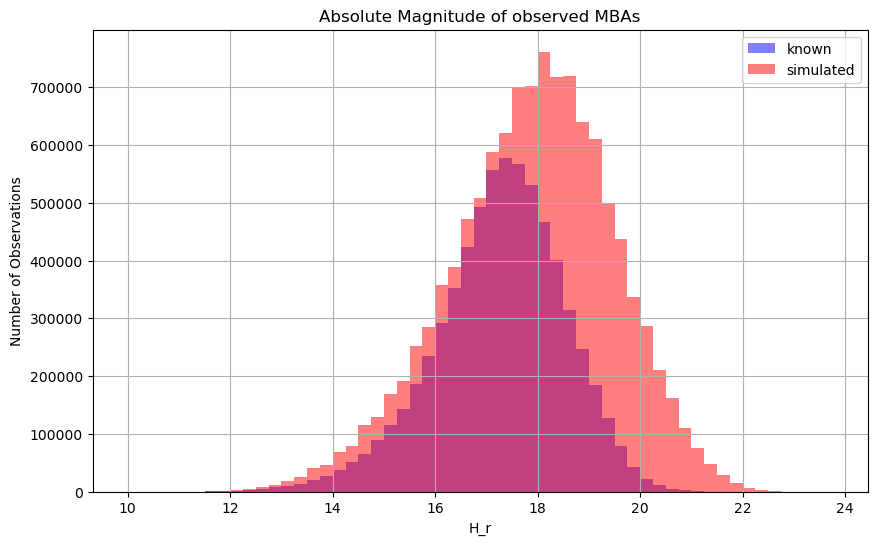

In [121]:
# makes histograms of absolute magnitudes of observed MBAs
# this is because TNOs don't have a file with all colors data

df_colors_mba=pd.read_csv('../results/sim-outputs/mba/colors_mba.csv')
df_mbatemp=df_mba.copy()
df_mbacolor=df_mbatemp.merge(df_colors_mba[["H_r","ObjID"]],on="ObjID")

dfr2_mba = dfrealtypescolors.query("type == 'MBA'")['H_r']
df3_data = df_mbacolor['H_r']

plt.figure(figsize=(10, 6))
bins=np.arange(10, 24, 0.25)
plt.hist(dfr2_mba, bins=bins, alpha=0.5, label='known', color='blue')

plt.hist(df3_data, bins=bins, alpha=0.5, label='simulated', color='red')

plt.title('Absolute Magnitude of observed MBAs')
plt.xlabel('H_r')
plt.ylabel('Number of Observations')
plt.legend()
plt.grid(True)

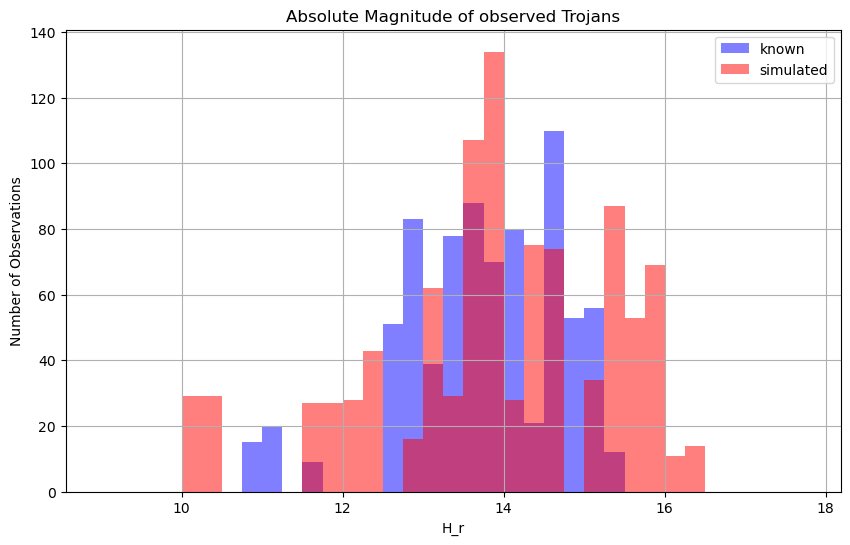

In [122]:
# makes histograms of absolute magnitudes of observed trojans
# this is because TNOs don't have a file with all colors data

df_colors_trojan=pd.read_csv('../results/sim-outputs/trojans/colors_trojans.csv')
df_trojantemp=df_trojans.copy()
df_trojancolor=df_trojantemp.merge(df_colors_trojan[["H_r","ObjID"]],on="ObjID")

dfr2_trojan = dfrealtypescolors.query("type == 'trojan'")['H_r']
df3_data = df_trojancolor['H_r']

plt.figure(figsize=(10, 6))
bins=np.arange(9, 18, 0.25)
plt.hist(dfr2_trojan, bins=bins, alpha=0.5, label='known', color='blue')

plt.hist(df3_data, bins=bins, alpha=0.5, label='simulated', color='red')

plt.title('Absolute Magnitude of observed Trojans')
plt.xlabel('H_r')
plt.ylabel('Number of Observations')
plt.legend()
plt.grid(True)